In [59]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input, concatenate, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.model_selection import train_test_split
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

seed = random.randint(1, 100)

In [60]:
drive.mount('/content/drive')

IMG_SIZE = 256

if IMG_SIZE == 256:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/256'
elif IMG_SIZE == 512:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/512'

input_path = os.path.join(path,"image")
mask_path = os.path.join(path,"binary_mask")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
image_input_path = sorted([ os.path.join(input_path, fname) for fname in os.listdir(input_path) if fname.endswith(".png") ])

image_mask_path = sorted([ os.path.join(mask_path, fname) for fname in os.listdir(mask_path) if fname.endswith(".png")])

path_df = pd.DataFrame({'image':image_input_path,'mask':image_mask_path})

In [62]:
train, val = train_test_split(path_df,test_size=0.1, random_state=seed)

train, test = train_test_split(train,test_size=0.11, random_state=seed)

In [63]:
#https://www.kaggle.com/code/iasonasxrist/mri-brain-tumour-segmentation-with-unet-cnn/notebook

EPOCHS = 100
BATCH_SIZE = 4

data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True)

imagegen = ImageDataGenerator(rescale=1/255, **data_augmentation)
maskgen = ImageDataGenerator(rescale=1/255, **data_augmentation)

def generator_fnctn(gen, dataframe, colour_mode, batch_size, column):
    gene = gen.flow_from_dataframe(dataframe=dataframe,
                                    x_col=column,
                                    batch_size= batch_size,
                                    seed=seed,
                                    class_mode=None,
                                    color_mode=colour_mode) 
    return gene

train_img_gen = generator_fnctn(imagegen, train, 'rgb', BATCH_SIZE, "image")

train_mask_gen = generator_fnctn(maskgen, train, 'grayscale', BATCH_SIZE, "mask")

imagegen = ImageDataGenerator(rescale=1/255)
maskgen = ImageDataGenerator(rescale=1/255)

val_image_gen = generator_fnctn(imagegen, val, 'rgb', BATCH_SIZE, "image")

val_mask_gen = generator_fnctn(maskgen, val, 'grayscale', BATCH_SIZE, "mask")

test_image_gen = generator_fnctn(imagegen, test, 'rgb', BATCH_SIZE, "image")

test_mask_gen = generator_fnctn(maskgen, test, 'grayscale', BATCH_SIZE, "mask")

def data_iterator(image_gen,mask_gen):
    for img, mask in zip(image_gen,mask_gen):
        yield img, mask

train_gen = data_iterator(train_img_gen, train_mask_gen)
val_gen = data_iterator(val_image_gen,val_mask_gen)
test_gen = data_iterator(test_image_gen,val_mask_gen)

Found 3114 validated image filenames.
Found 3114 validated image filenames.
Found 389 validated image filenames.
Found 389 validated image filenames.
Found 385 validated image filenames.
Found 385 validated image filenames.


In [64]:
def convolutional_layer_block(previous_layer, filter_size, kernel):
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(previous_layer)
        x = Dropout(0.05)(x)
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

def u_net(img_shape, n_classes):
    inputs = Input(shape=img_shape)
    previous_layer = inputs

    concatenate_link = []
    for filter_size in [32, 64, 128, 256]:
        x = convolutional_layer_block(previous_layer, filter_size, (3,3))
        concatenate_link.append(x)
        x = MaxPooling2D((2, 2))(x)
        previous_layer = x

    concatenate_link = list(reversed(concatenate_link))
    x = convolutional_layer_block(previous_layer, 160, (3,3))
    previous_layer = x

    for count,filter_size in enumerate([256, 128, 64, 32]):
        x = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same')(previous_layer)
        x = concatenate([x, concatenate_link[count]], axis = 3)
        convolutional_layer_block(x, filter_size, (3,3))
        previous_layer = x

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, kernel_size=(1, 1), activation=activation)(previous_layer)

    return Model(inputs=inputs, outputs=outputs)

model = u_net((IMG_SIZE, IMG_SIZE, 3), n_classes = 1)

In [65]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 256, 256, 32  0           ['conv2d_57[0][0]']              
                                )                                                           

In [66]:
model.compile(optimizer = Adam(), loss = "binary_crossentropy", metrics = ['accuracy'])

In [67]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(("/content/drive/MyDrive/"+'boundary_model_e100_bs4.h5'), verbose = 1, save_best_only=True, save_weights_only=True)]

In [68]:
train_step = train_img_gen.n/BATCH_SIZE
val_step = val_mask_gen.n/BATCH_SIZE

trained_model = model.fit(train_gen, steps_per_epoch = train_step, epochs= EPOCHS, validation_data = val_gen, validation_steps = val_step, callbacks = callbacks)

Epoch 1/100
778/778 [============================>.] - ETA: 0s - loss: 0.3800 - accuracy: 0.8267
Epoch 1: val_loss improved from inf to 0.34699, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
778/778 [==============================] - 80s 102ms/step - loss: 0.3800 - accuracy: 0.8267 - val_loss: 0.3470 - val_accuracy: 0.8637
Epoch 2/100
778/778 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.8299
Epoch 2: val_loss improved from 0.34699 to 0.32314, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
778/778 [==============================] - 77s 100ms/step - loss: 0.3425 - accuracy: 0.8299 - val_loss: 0.3231 - val_accuracy: 0.8666
Epoch 3/100
778/778 [============================>.] - ETA: 0s - loss: 0.3284 - accuracy: 0.8320
Epoch 3: val_loss improved from 0.32314 to 0.32043, saving model to /content/drive/MyDrive/boundary_model_e100_bs4.h5
778/778 [==============================] - 77s 99ms/step - loss: 0.3285 - accuracy: 0.8320 

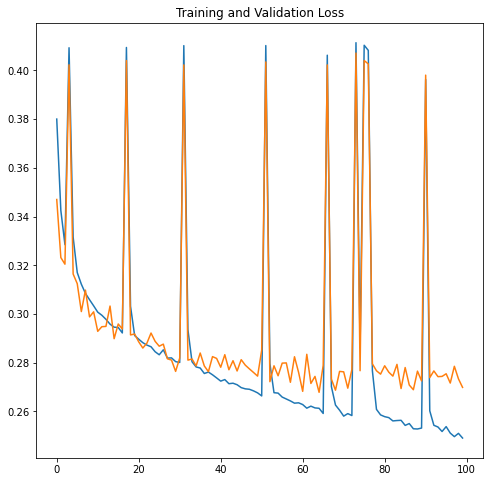

In [78]:
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']


def plot_training_data(graph_name, train_metric, val_metric):
    plt.figure(figsize = (8,8))
    plt.plot(train_metric, label = "Train")
    plt.plot(val_metric, label = "Validation")
    plt.title(graph_name)
    plt.legend(loc="upper left")
    plt.show()
    
plot_training_data("Training and Validation Loss", loss, val_loss)

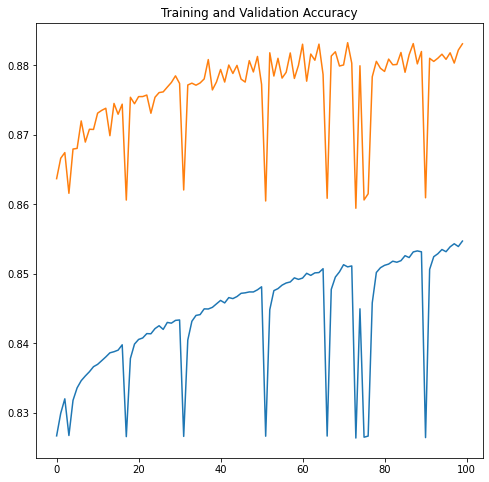

In [79]:
plot_training_data("Training and Validation Accuracy", accuracy, val_accuracy)

In [71]:
model.save("/content/drive/MyDrive/"+'boundary_model_e100_bs4.h5')

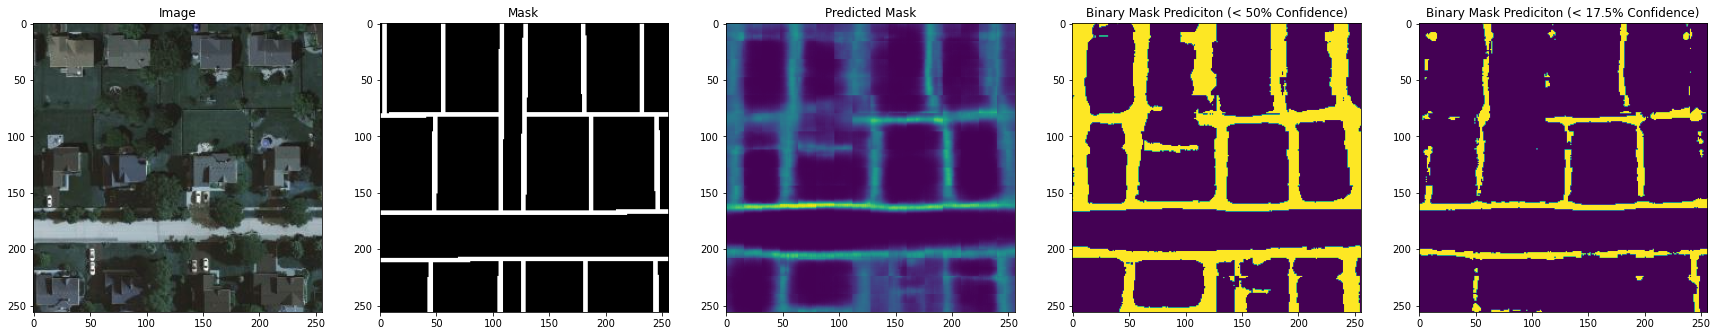

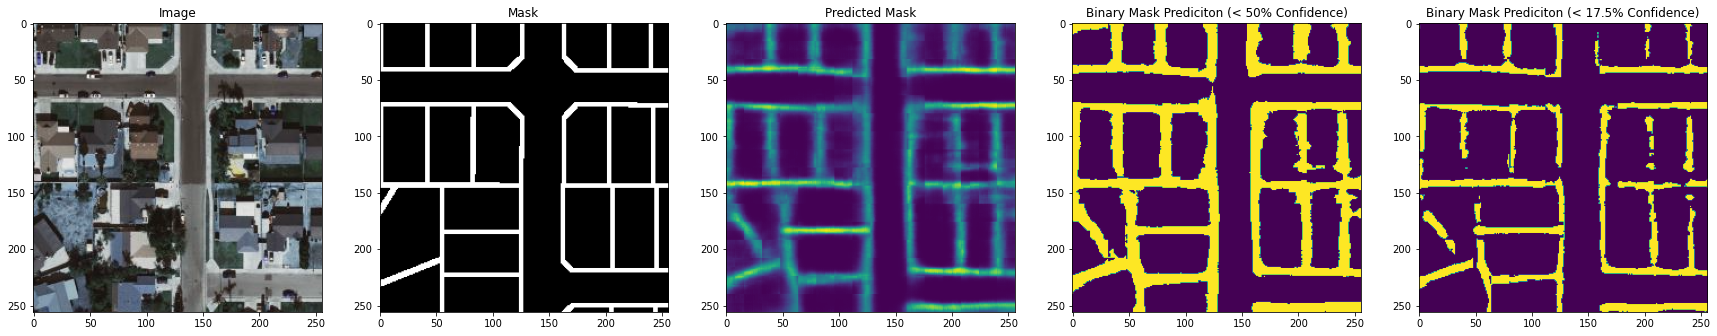

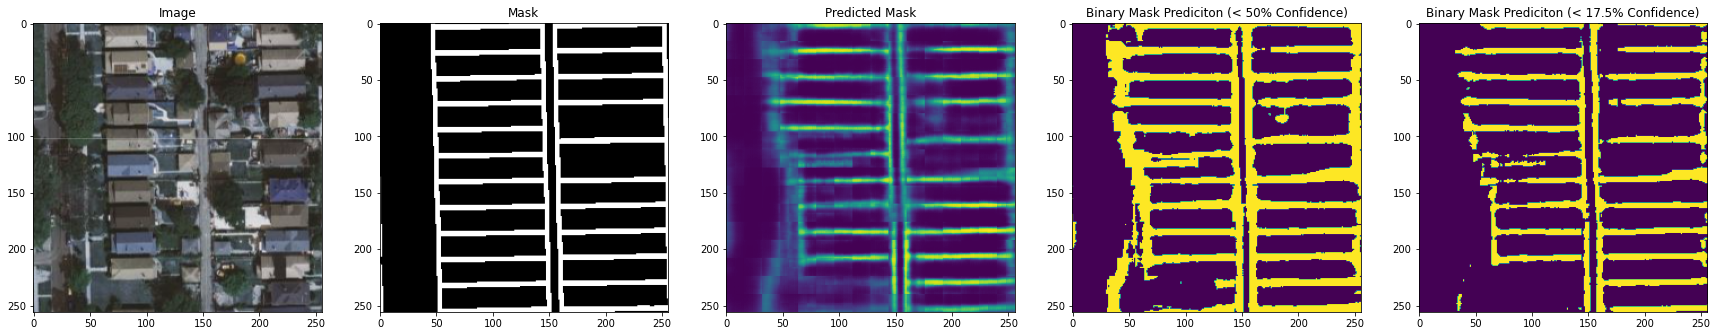

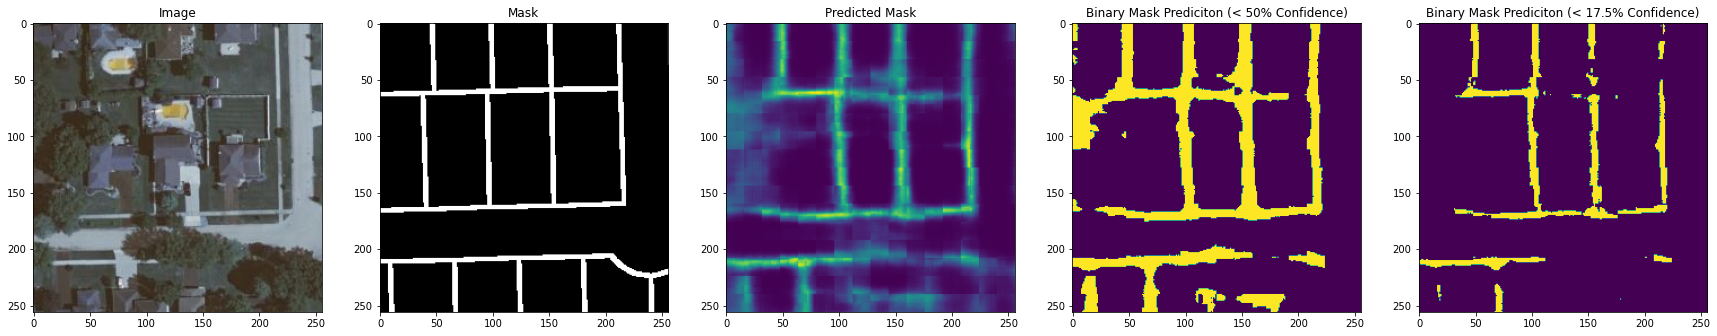

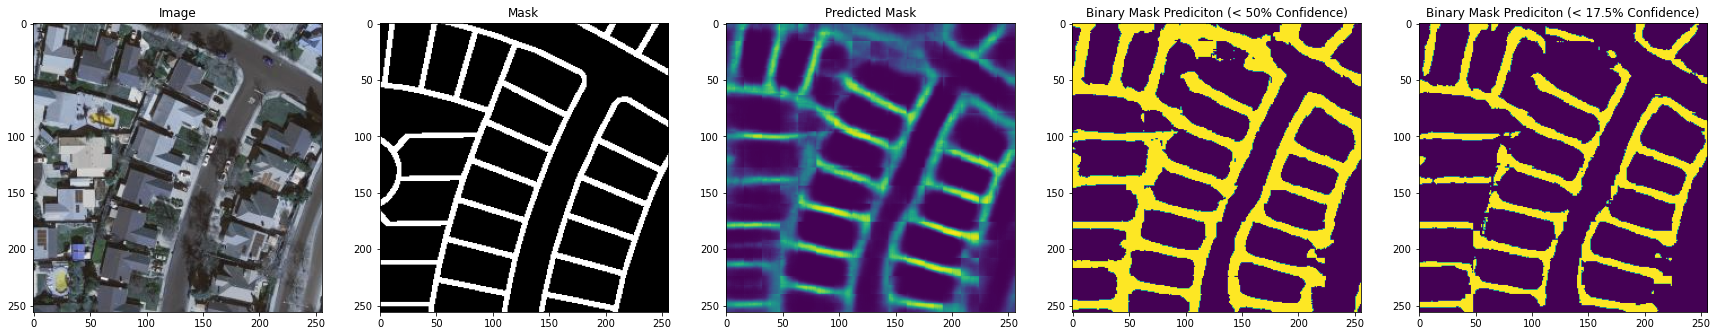

In [90]:
def predict_img(img_path,mask_path):
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
    image = image/255
    image = image[np.newaxis,:,:,:]
    pred_mask = model.predict(image) 
    return image, mask, pred_mask

def show_prediction(img,mask,pred_mask):
    plt.figure(figsize=(30,30))
    plt.subplot(1,5,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,5,2)
    plt.imshow(np.squeeze(mask))
    plt.title('Mask')
    plt.subplot(1,5,3)
    plt.imshow(np.squeeze(pred_mask))
    plt.title('Predicted Mask')
    plt.subplot(1,5,4)
    plt.imshow(np.squeeze(pred_mask) > 0.2)
    plt.title('Binary Mask Prediciton (< 50% Confidence)')
    plt.subplot(1,5,5)
    plt.imshow(np.squeeze(pred_mask) > 0.35)
    plt.title('Binary Mask Prediciton (< 17.5% Confidence)')
    plt.show()

for num in range(5):
    index = random.randint(1, len(path_df))
    img_path = path_df['image'][index]
    mask_path = path_df['mask'][index]
    img,mask,pred_mask =  predict_img(img_path,mask_path)
    show_prediction(img,mask,pred_mask)